In [1]:
# %%
#
# Imports
#
import os

import matplotlib.pyplot as plt  #  type: ignore
import numpy as np  #  type: ignore
import pandas as pd  #  type: ignore
from sklearn.datasets import make_regression  #  type: ignore
from sklearn.linear_model import LinearRegression  #  type: ignore
from sklearn.neighbors import KernelDensity  #  type: ignore
from tqdm import tqdm  #  type: ignore

In [5]:
def run_simulation(n_runs):
    
    def create_results_folder():
        if not os.path.exists("files/results"):
            os.makedirs("files/results")

    def generate_data():
        X, y = make_regression(
            n_samples=100,
            n_features=3,
            noise=0.1,
            random_state=42,
        )
        df = pd.DataFrame(X, columns=["x1", "x2", "x3"])
        df["dummy1"] = np.random.normal(0, 1, 100)
        df["dummy2"] = np.random.normal(0, 1, 100)
        df["y"] = y
        return df

    def get_model_params(df):
        X = df[["x1", "x2", "x3", "dummy1", "dummy2"]]
        y = df["y"]
        model = LinearRegression()
        model = model.fit(X, y)
        return {
            "x1": model.coef_[0],
            "x2": model.coef_[1],
            "x3": model.coef_[2],
            "dummy1": model.coef_[3],
            "dummy2": model.coef_[4],
            "intercept": model.intercept_,
        }

    def run_experiment(df, variable, n_runs):
        results = []
        params = get_model_params(df)
        result = {"variable": variable, "run": 0, "value": params[variable]}
        results.append(result)

        for i_run in tqdm(range(1, n_runs)):
            permuted_df = df.copy()
            permuted_df[variable] = np.random.permutation(permuted_df[variable].values)
            params = get_model_params(permuted_df)
            result = {"variable": variable, "run": i_run, "value": params[variable]}
            results.append(result)

        return pd.DataFrame(results)

    def run_experiments(df, n_runs):
        variables = ["x1", "x2", "x3", "dummy1", "dummy2"]
        results = pd.concat(
            [run_experiment(df, variable, n_runs) for variable in variables]
        )
        return results

    try:
        create_results_folder()
        df = generate_data()
        experiments = run_experiments(df, n_runs)
        experiments["run"] = experiments["run"].astype(int)
        experiments.to_csv("files/results/experiments.csv", index=False)
        return experiments
    except Exception as e:
        print(f"Error during simulation: {str(e)}")
        return None

# Run the simulation
results = run_simulation(n_runs=1000)


100%|██████████| 999/999 [00:02<00:00, 406.28it/s]


In [10]:
def compute_stats():
    try:
        # Read from the correct path (without ../)
        experiments = pd.read_csv("files/results/experiments.csv")

        # Extract coefficients for original dataset
        current_values = experiments.loc[experiments["run"] == 0].copy()
        current_values = current_values.drop(columns=["run"])
        current_values = current_values.rename(columns={"value": "original"})
        current_values = current_values.set_index("variable")

        # Calculate descriptive statistics
        stats = experiments[["variable", "value"]].groupby(["variable"]).describe()
        stats.columns = stats.columns.droplevel(0)

        # Add original values
        stats = stats.join(current_values, on="variable")

        # Generate report files in correct path
        with open("files/results/stats.txt", "w") as file:
            file.write(stats.to_string())
        stats.to_csv("files/results/stats.csv")
        
        return stats
    except Exception as e:
        print(f"Error computing stats: {str(e)}")
        return None

# Compute and display statistics
compute_stats()


,count,mean,std,min,25%,50%,75%,max,original
variable,,,,,,,,,
dummy1,1000.0,0.000241,0.012121,-0.040025,-0.007744,0.000615,0.008661,0.038790,-0.015076
dummy2,1000.0,-0.000174,0.010176,-0.032881,-0.007370,0.000160,0.006747,0.032225,0.008518
x1,1000.0,-0.004790,3.044642,-8.610670,-2.036100,0.171281,1.848644,28.204740,28.204740
x2,1000.0,0.020741,8.095169,-20.593421,-5.303698,-0.098817,5.215438,75.050343,75.050343
x3,1000.0,-0.028909,1.919747,-6.453651,-1.295091,-0.024545,1.238949,17.754636,17.754636


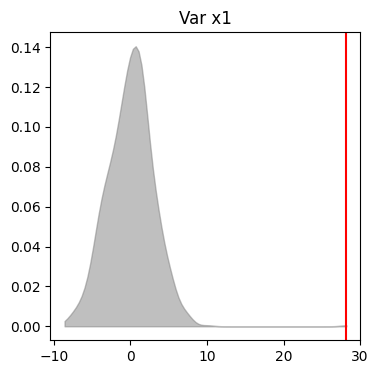

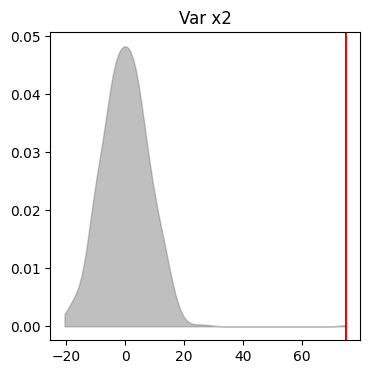

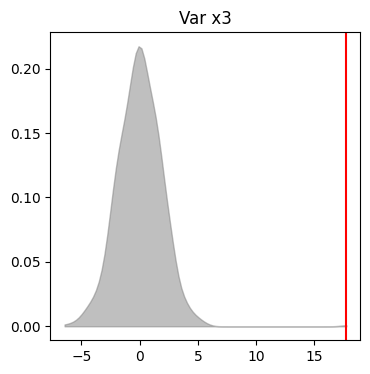

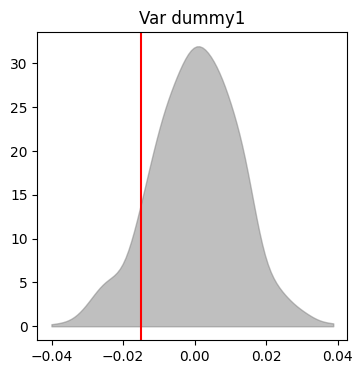

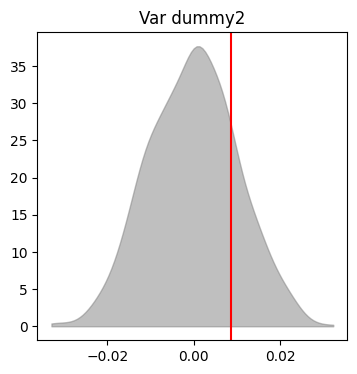

In [19]:
#
# Generación de gráficos de análisis
#
def make_plots():

    experiments = pd.read_csv("files/results/experiments.csv")

    for variable in experiments["variable"].drop_duplicates():

        plt.figure(figsize=(4, 4))

        sample = experiments[experiments["variable"] == variable].value
        x_min, x_max = sample.min(), sample.max()

        bandwidth = 1.06 * sample.std() * sample.size ** (-1 / 5)

        current_value = sample.iloc[0]
        kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(
            sample.values.reshape(-1, 1)
        )

        bins = np.linspace(x_min, x_max, 100)
        log_dens = kde.score_samples(bins.reshape(-1, 1))

        plt.fill_between(bins, np.exp(log_dens), alpha=0.5, color="gray")
        plt.axvline(current_value, color="red", linestyle="-")
        plt.title(f"Var {variable}")

        plt.show()
make_plots()